In [2]:
from urllib2 import urlopen, Request
from bs4 import BeautifulSoup
from pandas import DataFrame
import pandas as pd
import numpy as np
import re
import os.path 
import datetime 
import sys
import json

from __future__ import division

import nltk,re, pprint

In [49]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')


In [3]:
bs = BeautifulSoup(urlopen('http://www.playbill.com/article/broadway-real-estate-com-321997'))

In [28]:
Theatres = DataFrame([{'name': a.getText(), 'url': a['href'], 'address': a.nextSibling[2:]} 
                      for a in bs.find_all("a") if a.has_attr('href') and '/venue/' in a['href']])
Theatres

,address,name,url
0,"214 W 42nd St, New York, NY 10036",New Amsterdam Theatre,https://cms.playbill.com/venue/new-amsterdam-t...
1,"235 W 44th St, New York, NY 10036",Broadhurst Theatre,https://www.playbill.com/venue/broadhurst-thea...
2,"250 W 52nd St, New York, NY 10019",Neil Simon Theatre,https://www.playbill.com/venue/neil-simon-thea...
3,"243 W 47th St, New York, NY 10036",Barrymore Theatre,http://www.playbill.com/venue/ethel-barrymore-...
4,"124 W 43rd St, New York, NY 10036",Stephen Sondheim Theatre,https://www.playbill.com/venue/stephen-sondhei...
5,"230 W 49th St, New York, NY 10019",Eugene O'Neill Theatre,https://www.playbill.com/venue/eugene-oneill-t...
6,"220 W 48th St, New York, NY 10036",Longacre Theatre,https://www.playbill.com/venue/longacre-theatr...
7,"249 W 45th St, New York, NY 10036",Imperial Theatre,http://www.playbill.com/venue/imperial-theatre...
8,"219 W 49th St, New York, NY 10019",Ambassador Theatre,http://www.playbill.com/venue/ambassador-theat...
9,"254 W 54th St, New York, NY 10019",Studio 54,http://www.playbill.com/venue/studio-54-vault-...


In [83]:
print Theatres['url'][0]

https://cms.playbill.com/venue/new-amsterdam-theatre-vault-0000000276


In [36]:
bs = BeautifulSoup(urlopen('http://www.playbill.com/venue/george-gershwin-theatre-vault-0000000339'))


In [57]:
bss = [BeautifulSoup(urlopen(url)) for url in list(Theatres['url'])]

In [93]:
nltk.Text(nltk.word_tokenize(''.join(theaterDescriptions))).collocations()

Read Full; New York; Theatre opened; City landmark; Martin Beck;
Public Transportation; Winter Garden; 42nd St.; 46th Street; Times
Square; John Golden; Shubert Organization; Street New; Chanin
brothers; seating capacity; York City; St. James; August Wilson;
Brooks Atkinson; Helen Hayes


In [91]:
theaterDescriptions = []

for i in range(39):    
    print i
    
    try:
        bs = bss[i]

        bspBio = bs.find('div', class_='bsp-bio')

        bspBioTitle = bspBio.find('h2', class_='bsp-bio-title').getText()

        print bspBioTitle

        bspBioText = ''
        bspBioFullTextUrl = ''
        if (bspBio.find('div', class_='bsp-bio-text')):
            bspBioText =  bspBio.find('div', class_='bsp-bio-text').getText('\n')
            if (bspBio.find('div', class_='bsp-bio-text').find('a')):
                if (bspBio.find('div', class_='bsp-bio-text').find('a').has_attr('href')):
                    bspBioFullTextUrl = bspBio.find('div', class_='bsp-bio-text').find('a')['href']

        bspBioLists =bspBio.find('div', class_='bsp-bio-lists')
        bspBioListPairs = [(re.sub(':$', '', li.find('span').getText()), li.find('span').nextSibling) for li in bspBioLists.find_all('li')]


        print bspBioText
        theaterDescriptions.append(bspBioText)
        
        print bspBioFullTextUrl
        print bspBioListPairs
    except:
        print("Unexpected error:", sys.exc_info()[0])

0
New Amsterdam Theatre

                    The New Amsterdam Theatre, unique in its Art Nouveau architecture, was erected in 1903 at 214 W. 42nd Street. Most notably, Florenz Ziegfeld began presenting his legendary 
Follies
 productions here in 1913. The New Amsterdam became a New York City landmark in 1982, but the theatre’s interior was in poor condition from the building’s damaged roof. Following a complete restoration by the Walt Disney Company, the theatre stands today as a designated New York City landmark.
Public Transportation:  
Take the N/Q/R/W or 1/2/3 to 42nd St., walk West to the theatre
OR
Take the A/C/E to 42nd St., walk East to the theatre
Parking:  
Kinney System
264 West 42nd Street
New York, NY 10036
212-997-5543
 
Imperial Parking
315 West 42nd Street
New York, NY 10036
212-975-9968
Handicap:
Accessible seating is available in Orchestra Row V and Mezzanine Row LL through the Box Office only. Call the Box Office for more information.
 
Read Full "At This Theatre"



In [101]:
season2017 = json.loads(''.join(urlopen('http://www.playbill.com/ajax/loadProdSeason.jsp?year=2017&start=0&limit=1000').readlines()))


In [24]:
def seasonShows(season):
    seasonJson = json.loads(''.join(urlopen('http://www.playbill.com/ajax/loadProdSeason.jsp?year='+str(season)+'&start=0&limit=1000').readlines()))
    result = []
    for row in seasonJson['rows']:

        bs = BeautifulSoup(row)
        if (bs.find('a').has_attr('href')):
            result.append({'url':bs.find('a')['href'], 'title': bs.find('a').getText()})
    return result

In [25]:
seasonShows(2017)

[{'title': u'   1984 \n', 'url': '/production/1984-hudson-theatre-2017-2018'},
 {'title': u"   Marvin's Room \n",
  'url': '/production/marvins-room-american-airlines-theatre-2017-2018'},
 {'title': u'   Michael Moore: The Terms of My Surrender \n',
  'url': '/production/the-terms-of-my-surrender-belasco-theatre-2017-2018'},
 {'title': u'   Prince of Broadway \n',
  'url': '/production/prince-of-broadway-samuel-j-friedman-theatre-2017-2018'},
 {'title': u'   Time and the Conways \n',
  'url': '/production/time-and-the-conways-american-airlines-theatre-2017-2018'},
 {'title': u'   Springsteen On Broadway \n',
  'url': '/production/springsteen-on-broadway-walter-kerr-theatre-2017-2018'},
 {'title': u'   M. Butterfly \n', 'url': '/production/m-butterfly-2017-2018'},
 {'title': u'   Junk \n',
  'url': '/production/junk-vivian-beaumont-theater-2017-2018'},
 {'title': u"   The Band's Visit \n",
  'url': '/production/the-bands-visit-ethel-barrymore-theatre-2017-2018'},
 {'title': u'   Latin H

In [30]:
Shows = DataFrame([{'year': year, 'url': x['url'], 'title': x['title']}  for year in range(1701,2018) for x in seasonShows(year)])

In [31]:
Shows

,title,url,year
0,The Recruiting Officer \n,/production/the-recruiting-officer-new-theatre...,1732
1,The Mock Doctor \n,/production/the-mock-doctor-nassau-street-thea...,1749
2,The Devil to Pay \n,/production/the-devil-to-pay-nassau-street-the...,1749
3,Damon and Phillida \n,/production/damon-and-phillida-nassau-street-t...,1749
4,Richard III \n,/production/king-richard-iii-nassau-street-the...,1749
5,Spanish Friar \n,/production/spanish-friar-nassau-street-theatr...,1749
6,The Orphan \n,/production/the-orphan-nassau-street-theatre-v...,1749
7,The Stage Coach \n,/production/the-stage-coach-nassau-street-thea...,1750
8,Love for Love \n,/production/love-for-love-nassau-street-theatr...,1750
9,The Recruiting Officer \n,/production/the-recruiting-officer-nassau-stre...,1750


In [38]:
Shows['title'] = Shows['title'].str.strip()

In [39]:
Shows.to_csv('Shows.csv',index=False,encoding='utf-8')

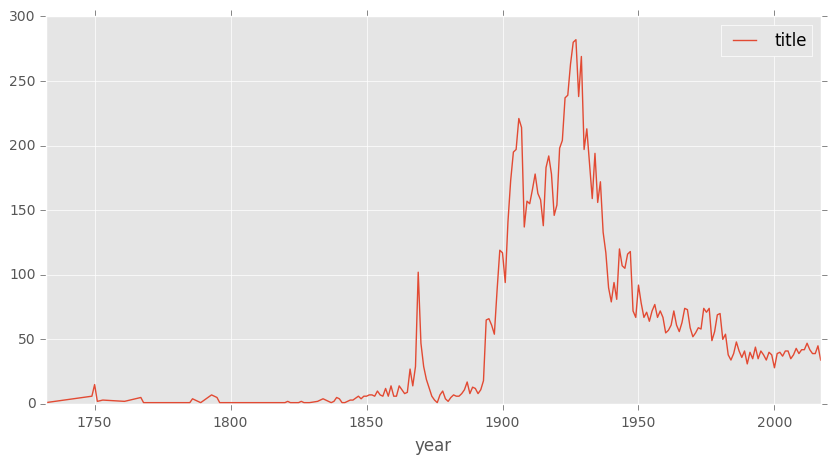

In [63]:
Shows.groupby('year').count()[['title']].plot(figsize=(10,5))